## Unsupervised Clustering: DBSCAN on Obesity Data

### Overview

**Density-Based Spatial Clustering of Applications with Noise (DBSCAN)**

This notebook demonstrates the application of the custom DBSCAN implementation from the `rice_ml` package to discover natural groupings (communities) within the `Obesity_Dataset.csv`. DBSCAN is particularly effective at identifying arbitrarily shaped clusters and separating noise, unlike centroid-based methods like K-Means.

#### **1. Setup and Data Loading**

In [ ]:
# ------------------------
# Core imports
# ------------------------

import pandas as pd
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ------------------------
# Setup repo and src path
# ------------------------
# Set path to the repo root and src folder
# NOTE: Update this path to your local environment if necessary
repo_root = Path("/Users/ruchitiwari/Desktop/Final CMOR 438/CMOR_438_Final_Repository")
src_path = repo_root / "src"
# Append src path to system path to import custom package
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

# Import custom utilities and the DBSCAN model
from rice_ml.processing.preprocessing import standardize
from rice_ml.unsupervised_learning.dbscan import DBSCANCommunityDetector

#### **2. Dataset Loading and Exploratory Data Analysis (EDA)**
We load the Obesity_Dataset.csv and perform initial inspection.

In [5]:
data_path = repo_root / "Data" / "Obesity_Dataset.csv"
df = pd.read_csv(data_path)

print(f"Dataset loaded with {df.shape[0]} samples and {df.shape[1]} features.")
display(df.head())

Dataset loaded with 2111 samples and 17 features.


,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.0,Female,1.62,64.0,no,no,2.0,3.0,no,no,2.0,yes,0.0,1.0,Sometimes,Public_Transportation,Normal_Weight
1,21.0,Female,1.52,56.0,Sometimes,no,3.0,3.0,yes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,23.0,Male,1.80,77.0,Frequently,no,2.0,3.0,no,no,2.0,yes,2.0,1.0,Sometimes,Public_Transportation,Normal_Weight
3,27.0,Male,1.80,87.0,Frequently,no,3.0,3.0,no,no,2.0,no,2.0,0.0,Sometimes,Walking,Overweight_Level_I
4,22.0,Male,1.78,89.8,Sometimes,no,2.0,1.0,no,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [6]:
# Check for data types and missing values
print("\nData types:")
display(df.dtypes)
print("\nMissing values per column:")
display(df.isnull().sum())

# Reference label distribution (the true labels, not used for training)
print("\nDistribution of NObeyesdad:")
display(df["NObeyesdad"].value_counts())


Data types:


Age                               float64
Gender                             object
Height                            float64
Weight                            float64
CALC                               object
FAVC                               object
FCVC                              float64
NCP                               float64
SCC                                object
SMOKE                              object
CH2O                              float64
family_history_with_overweight     object
FAF                               float64
TUE                               float64
CAEC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object


Missing values per column:


Age                               0
Gender                            0
Height                            0
Weight                            0
CALC                              0
FAVC                              0
FCVC                              0
NCP                               0
SCC                               0
SMOKE                             0
CH2O                              0
family_history_with_overweight    0
FAF                               0
TUE                               0
CAEC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


Distribution of NObeyesdad:


NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

##### 2.1 Feature Distributions
The variability and scale of numeric features (like Age, Height, Weight) directly impact the Euclidean distance, which is the basis for DBSCAN's neighborhood definition ($\epsilon$).

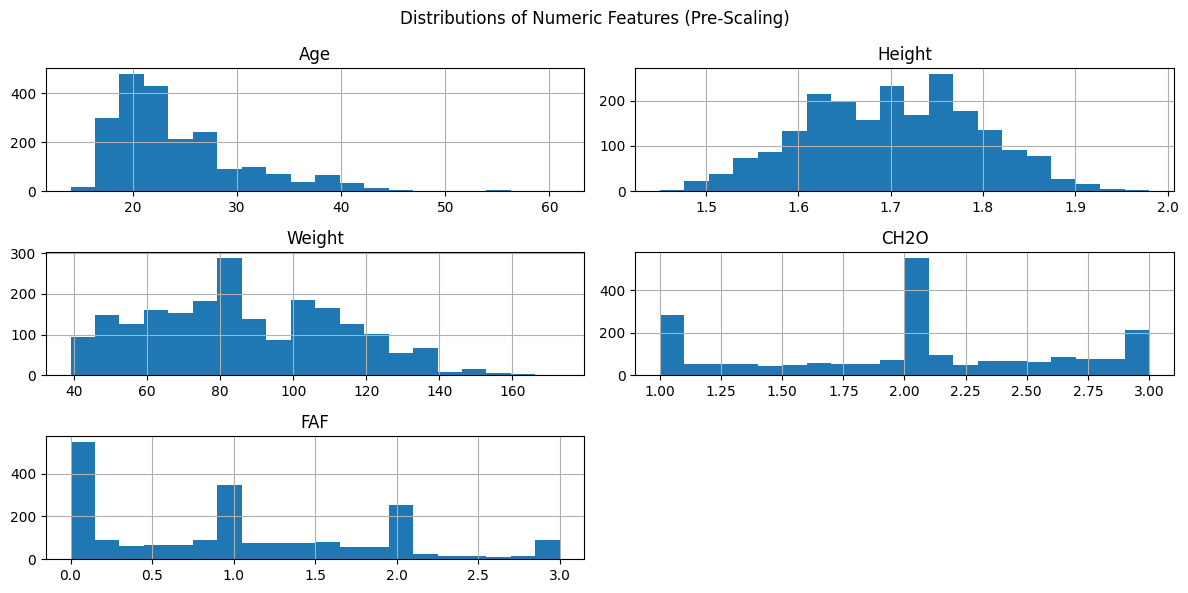


---
Analysis Note: The distributions show varying scales and ranges. Since DBSCAN relies on Euclidean distance, standardizing the data is critical to ensure all features contribute equally to the neighborhood calculation.
---



In [7]:
# Numeric Feature Distributions (Visualizing scale disparity)
numeric_cols = ["Age", "Height", "Weight", "CH2O", "FAF"]

df[numeric_cols].hist(bins=20, figsize=(12, 6))
plt.suptitle("Distributions of Numeric Features (Pre-Scaling)")
plt.tight_layout()
plt.show()

print("\n---")
print("Analysis Note: The distributions show varying scales and ranges. Since DBSCAN relies on Euclidean distance, standardizing the data is critical to ensure all features contribute equally to the neighborhood calculation.")
print("---\n")

##### 2.2 Density Visualization (Age vs Weight)
This scatter/hexbin plot illustrates the underlying density structure of the data, which DBSCAN is designed to exploit. Dense regions will form clusters; sparse regions will be labeled as noise.

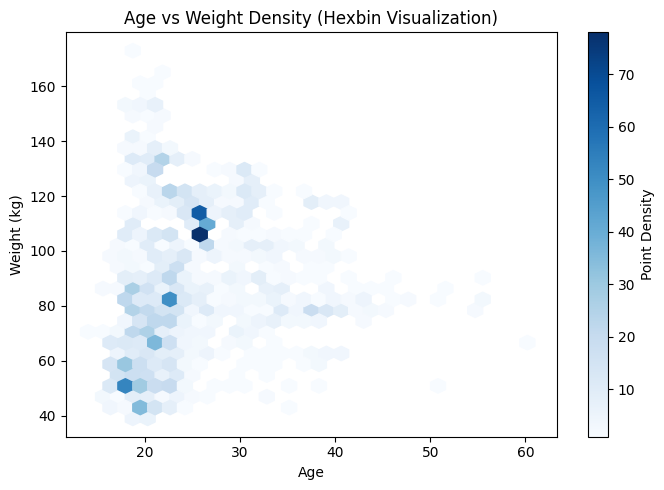

In [8]:
# Age vs Weight Density (Hexbin Plot - directly motivating density-based clustering)
plt.figure(figsize=(7, 5))
plt.hexbin(
    df["Age"],
    df["Weight"],
    gridsize=30,
    cmap="Blues",
    mincnt=1
)
plt.colorbar(label="Point Density")
plt.title("Age vs Weight Density (Hexbin Visualization)")
plt.xlabel("Age")
plt.ylabel("Weight (kg)")
plt.tight_layout()
plt.show()

#### **3. Preprocessing and Feature Engineering**
We will encode categorical features and then standardize all numeric features using the custom standardize function from rice_ml.processing.preprocessing.

In [9]:
# Encode categorical variables using pandas (not part of the custom package)
df_encoded = pd.get_dummies(df.drop(columns=['NObeyesdad']), drop_first=True)

# Select features for custom scaling
X = df_encoded.to_numpy()

# Standardize features using the custom rice_ml utility
X_scaled = standardize(X)

print(f"Original feature matrix shape: {df_encoded.shape}")
print(f"Scaled feature matrix shape: {X_scaled.shape}")

Original feature matrix shape: (2111, 23)
Scaled feature matrix shape: (2111, 23)


#### **4. Custom DBSCAN Clustering**
We now use our custom DBSCANCommunityDetector class to perform the clustering. The choice of the hyperparameters $\epsilon$ (eps) and min_samples is crucial.
- Epsilon ($\epsilon$): Determines the maximum size of the neighborhood.
- Min Samples: Determines the density requirement for a point to be a core point.

Model Training and Results

In [10]:
# Hyperparameters for DBSCAN (based on prior exploration/heuristics)
EPSILON = 1.5
MIN_SAMPLES = 10

# Initialize and fit the custom DBSCAN model
dbscan_custom = DBSCANCommunityDetector(eps=EPSILON, min_samples=MIN_SAMPLES)
db_labels = dbscan_custom.fit_predict(X_scaled)

# Add cluster labels back to the DataFrame for analysis
df['dbscan_cluster'] = db_labels

# Basic cluster info
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = list(db_labels).count(-1)

print(f"DBSCAN Parameters: eps={EPSILON}, min_samples={MIN_SAMPLES}")
print(f"Number of clusters detected: {n_clusters}")
print(f"Number of noise points (label -1): {n_noise}")

# Cluster size distribution
cluster_sizes = pd.Series(db_labels).value_counts().sort_index()
print("\nCluster size distribution (including noise -1):")
print(cluster_sizes)

DBSCAN Parameters: eps=1.5, min_samples=10
Number of clusters detected: 20
Number of noise points (label -1): 1057

Cluster size distribution (including noise -1):
-1     1057
 0      281
 1       30
 2       26
 3       17
 4      324
 5       21
 6       37
 7       10
 8       13
 9       14
 10      74
 11      10
 12      12
 13      13
 14      79
 15      11
 16      11
 17      10
 18      10
 19      51
Name: count, dtype: int64


/Users/ruchitiwari/Desktop/Final CMOR 438/CMOR_438_Final_Repository/src/rice_ml/unsupervised_learning/dbscan.py:64: RuntimeWarning: divide by zero encountered in matmul
  D2 = np.maximum(aa + bb - 2.0 * XA @ XB.T, 0.0)
/Users/ruchitiwari/Desktop/Final CMOR 438/CMOR_438_Final_Repository/src/rice_ml/unsupervised_learning/dbscan.py:64: RuntimeWarning: overflow encountered in matmul
  D2 = np.maximum(aa + bb - 2.0 * XA @ XB.T, 0.0)
/Users/ruchitiwari/Desktop/Final CMOR 438/CMOR_438_Final_Repository/src/rice_ml/unsupervised_learning/dbscan.py:64: RuntimeWarning: invalid value encountered in matmul
  D2 = np.maximum(aa + bb - 2.0 * XA @ XB.T, 0.0)


#### **5. Cluster Analysis and Interpretation**
We analyze the characteristic features of the detected clusters to give them meaning in the context of the Obesity dataset. Noise points (-1) are typically excluded from this analysis.

In [ ]:
# Exclude noise points (-1) for analysis
clusters_to_analyze = [c for c in set(db_labels) if c != -1]


# Build summary dataframe
X_summary_df = df_encoded.copy()
X_summary_df["dbscan_cluster"] = db_labels

# Numeric feature averages per cluster
print("\n--- Average Feature Values per Cluster (Original Scales) ---")

numeric_summary = (
    X_summary_df[X_summary_df["dbscan_cluster"].isin(clusters_to_analyze)]
    .groupby("dbscan_cluster")[numeric_cols]
    .mean()
)

display(numeric_summary.round(3))

# Categorical feature dominance (one-hot)
print("\n--- Encoded Feature Sums per Cluster ---")

categorical_cols = [
    col for col in X_summary_df.columns
    if col not in numeric_cols and col != "dbscan_cluster"
]

categorical_summary = (
    X_summary_df[X_summary_df["dbscan_cluster"].isin(clusters_to_analyze)]
    .groupby("dbscan_cluster")[categorical_cols]
    .sum()
)

# Transpose for readability (features as rows)
display(categorical_summary.T)


--- Average Feature Values per Cluster (Original Scales) ---


,Age,Height,Weight,CH2O,FAF
dbscan_cluster,,,,,
0,23.176,1.790,101.432,2.188,1.066
1,38.080,1.566,77.221,1.530,0.108
2,21.200,1.624,69.560,2.831,0.880
3,24.144,1.593,80.233,2.006,0.219
4,23.454,1.687,120.506,2.199,0.662
5,20.065,1.533,41.929,1.281,0.093
6,18.046,1.817,58.575,2.154,2.068
7,22.281,1.592,44.120,2.442,1.279
8,18.010,1.729,48.847,1.647,2.034



--- Encoded Feature Sums per Cluster ---


dbscan_cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
FCVC,636.407024,63.638321,51.910176,34.449151,971.805512,61.044208,92.525598,28.436262,35.773371,24.822980,147.840343,25.243881,24.821553,26.000000,182.210052,24.890304,30.877540,27.967345,22.587731,143.703923
NCP,831.418309,87.613395,29.113163,18.788128,971.880817,22.154765,137.898994,22.476531,45.016614,23.408274,209.703108,30.632369,24.092742,21.639786,234.363623,14.125722,12.453588,30.000000,29.367470,91.220169
TUE,153.074071,0.579831,0.207922,2.593362,197.624460,9.580212,30.530058,0.000000,14.167364,11.702330,92.296047,11.168781,2.002730,14.163845,60.807880,0.000000,13.447481,8.075447,8.286549,38.557379
Gender_Male,281.000000,0.000000,26.000000,0.000000,0.000000,0.000000,37.000000,0.000000,0.000000,14.000000,74.000000,0.000000,12.000000,13.000000,79.000000,0.000000,0.000000,0.000000,0.000000,51.000000
CALC_Frequently,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CALC_Sometimes,281.000000,30.000000,26.000000,0.000000,324.000000,21.000000,0.000000,0.000000,13.000000,14.000000,0.000000,0.000000,12.000000,0.000000,79.000000,11.000000,0.000000,0.000000,10.000000,0.000000
CALC_no,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,37.000000,10.000000,0.000000,0.000000,74.000000,10.000000,0.000000,13.000000,0.000000,0.000000,11.000000,10.000000,0.000000,51.000000
FAVC_yes,281.000000,30.000000,26.000000,17.000000,324.000000,21.000000,37.000000,0.000000,13.000000,14.000000,74.000000,0.000000,12.000000,13.000000,79.000000,11.000000,11.000000,10.000000,10.000000,51.000000
SCC_yes,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SMOKE_yes,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### **6. Visualization using Custom PCA**
To visualize the clusters in a meaningful 2D space, we use the custom PCA utility implemented within the DBSCANCommunityDetector class (since the data was standardized before fitting, it's ready for PCA).

PCA Variance Explained Ratio (Top 2): [0.1377, 0.0918]


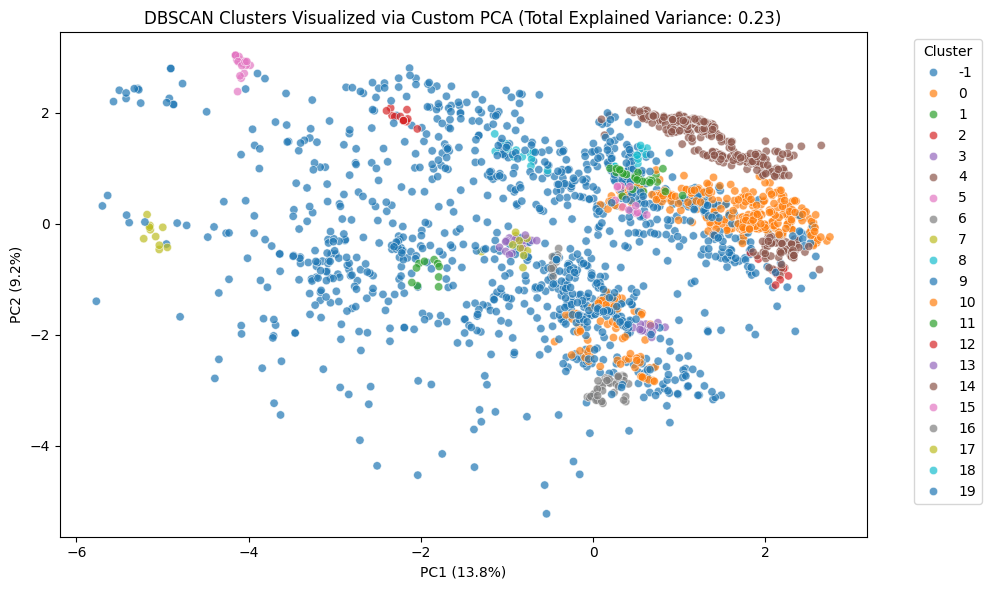

In [13]:
# Use the custom PCA utility
n_components_pca = 2
X_pca, evr = dbscan_custom.pca_transform(n_components=n_components_pca)

print(f"PCA Variance Explained Ratio (Top {n_components_pca}): {evr.round(4).tolist()}")

plt.figure(figsize=(10, 6))
# Noise points (-1) should be clearly separated from clustered points
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df['dbscan_cluster'],
    palette="tab10",
    legend="full",
    alpha=0.7
)
plt.title(f"DBSCAN Clusters Visualized via Custom PCA (Total Explained Variance: {evr.sum():.2f})")
plt.xlabel(f"PC1 ({evr[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({evr[1]*100:.1f}%)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()